In [1]:
import seaborn as sns
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    make_scorer,
)
from skopt import BayesSearchCV

In [2]:
data_path = r'C:\Users\quantum1\OneDrive\Documents\Python Scripts\Important Blue Fridge Python Files\New\OPX_setup_06022025\opx_github_scripts\Data\2025-06-06\#450_state_readout_141939\arrays.npz'

data = np.load(data_path)

In [3]:
# Prepare an empty list to store rows
rows = []

# Mapping from label string to integer
label_map = {'g': 0, 'e': 1, 'f': 2}

# For each state
for state in ['g', 'e', 'f']:
    row = {}
    # Extract and flatten the arrays if needed (depending on their shape)
    I1 = data[f'I1{state}_data'].flatten()
    Q1 = data[f'Q1{state}_data'].flatten()
    I2 = data[f'I2{state}_data'].flatten()
    Q2 = data[f'Q2{state}_data'].flatten()
    label = label_map[state]
    # Combine as rows, one per datapoint
    n_points = len(I1)
    for i in range(n_points):
        rows.append({
            'I1': I1[i],
            'Q1': Q1[i],
            'I2': I2[i],
            'Q2': Q2[i],
            'label': label
        })

# Create DataFrame
df = pd.DataFrame(rows)

# Check result
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.head()
three_state = df

In [4]:
three_state

,I1,Q1,I2,Q2,label
0,-0.000574,-0.000645,-0.001205,-0.002445,0
1,0.000122,-0.001516,-0.001604,-0.002391,2
2,0.000209,-0.001209,-0.001175,-0.001999,2
3,-0.000105,-0.001411,-0.001357,-0.001958,2
4,-0.000874,-0.000648,-0.001745,-0.001992,0
...,...,...,...,...,...
29995,0.000087,-0.001450,-0.001368,-0.002196,2
29996,-0.000748,-0.000972,-0.001626,-0.001859,0
29997,-0.000770,-0.000968,-0.001228,-0.002503,0
29998,-0.000674,-0.000911,-0.000026,-0.002260,1


In [5]:
# Define features (X) and labels (y)
X = three_state.drop(columns=["label"])  # All columns except "label"
y = three_state["label"]  # Target labels

# Split into 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [6]:
precision_scorer = make_scorer(precision_score, average="weighted")
# Initialize LightGBM model with default parameters
lgbm = lgb.LGBMClassifier(objective="multiclass", num_class=3, n_jobs=-1)

# hyperparameter tuning
param_serach = {
    "num_leaves": (20, 40),
    "learning_rate": (0.05, 0.3, "log-uniform"),
    "n_estimators": (50, 250),
    "max_depth": (2, 15),
    "min_child_samples": (10, 80),
    "subsample": (0.5, 1.0, "uniform"),
    "colsample_bytree": (0.1, 1.0, "uniform"),
}

cv = StratifiedKFold(n_splits=5, shuffle=True)

bayes_search = BayesSearchCV(
    estimator=lgbm,
    search_spaces=param_serach,
    n_iter=20,
    scoring=precision_scorer,
    cv=cv,
    n_jobs=-1,
    verbose=0,
)

bayes_search.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 4
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
              estimator=LGBMClassifier(n_jobs=-1, num_class=3,
                                       objective='multiclass'),
              n_iter=20, n_jobs=-1,
              scoring=make_scorer(precision_score, response_method='predict', average=weighted),
              search_spaces={'colsample_bytree': (0.1, 1.0, 'uniform'),
                             'learning_rate': (0.05, 0.3, 'log-uniform'),
                             'max_depth': (2, 15),
                             'min_child_samples': (10, 80),
                             'n_estimators': (50, 250), 'num_leaves': (20, 40),
                             'subsample': (0.5, 1.0, 'uniform')})

In [7]:
# Train the model on full training data
best_lgbm = bayes_search.best_estimator_
best_lgbm.fit(X_train, y_train)

# Predict on test set
y_pred = best_lgbm.predict(X_test)

# Compute accuracy
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred, average="weighted")
conf_matrix = confusion_matrix(y_test, y_pred, normalize="true")
print(f"Best Hyperparameters: {bayes_search.best_params_}")
print(f"Best CV Score: {bayes_search.best_score_:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(conf_matrix)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 4
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Best Hyperparameters: OrderedDict([('colsample_bytree', 0.8258326988693223), ('learning_rate', 0.09906560679749005), ('max_depth', 13), ('min_child_samples', 59), ('n_estimators', 76), ('num_leaves', 21), ('subsample', 0.549553143126442)])
Best CV Score: 0.9344
Test Precision: 0.9371
Test Accuracy: 0.9300
[[0.9935 0.004  0.0025]
 [0.114  0.8815 0.0045]
 [0.0595 0.0255 0.915 ]]


In [8]:
import joblib

# save model
joblib.dump(best_lgbm, "lgb.pkl")

['lgb.pkl']

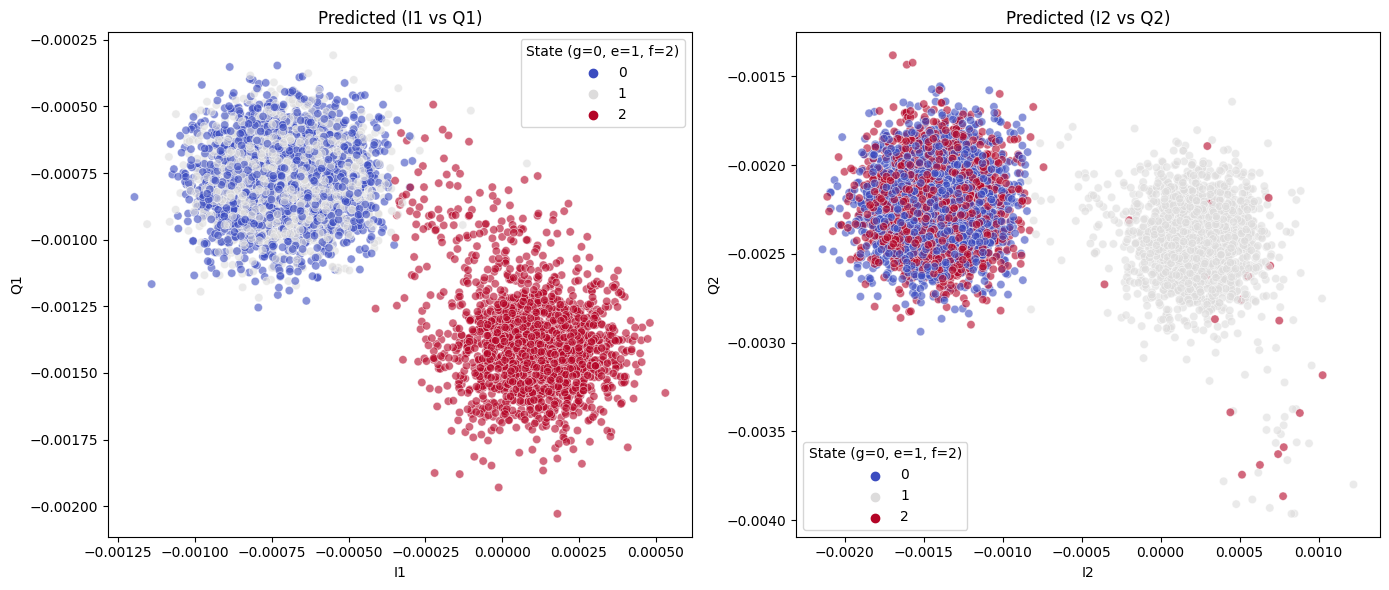

In [9]:
# Convert test data into a DataFrame for easier plotting
test_df = pd.DataFrame(X_test, columns=["I1", "Q1", "I2", "Q2"])
test_df["label"] = y_test  # Add true labels
test_df["predicted"] = y_pred  # Add predicted labels

# Create subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First subplot: I1 vs Q1
sns.scatterplot(
    data=test_df,
    x="I1",
    y="Q1",
    hue="predicted",
    palette="coolwarm",
    alpha=0.6,
    ax=axes[0],
)
axes[0].set_xlabel("I1")
axes[0].set_ylabel("Q1")
axes[0].set_title("Predicted (I1 vs Q1)")
axes[0].legend(title="State (g=0, e=1, f=2)")

# Second subplot: I2 vs Q2
sns.scatterplot(
    data=test_df,
    x="I2",
    y="Q2",
    hue="predicted",
    palette="coolwarm",
    alpha=0.6,
    ax=axes[1],
)
axes[1].set_xlabel("I2")
axes[1].set_ylabel("Q2")
axes[1].set_title("Predicted (I2 vs Q2)")
axes[1].legend(title="State (g=0, e=1, f=2)")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

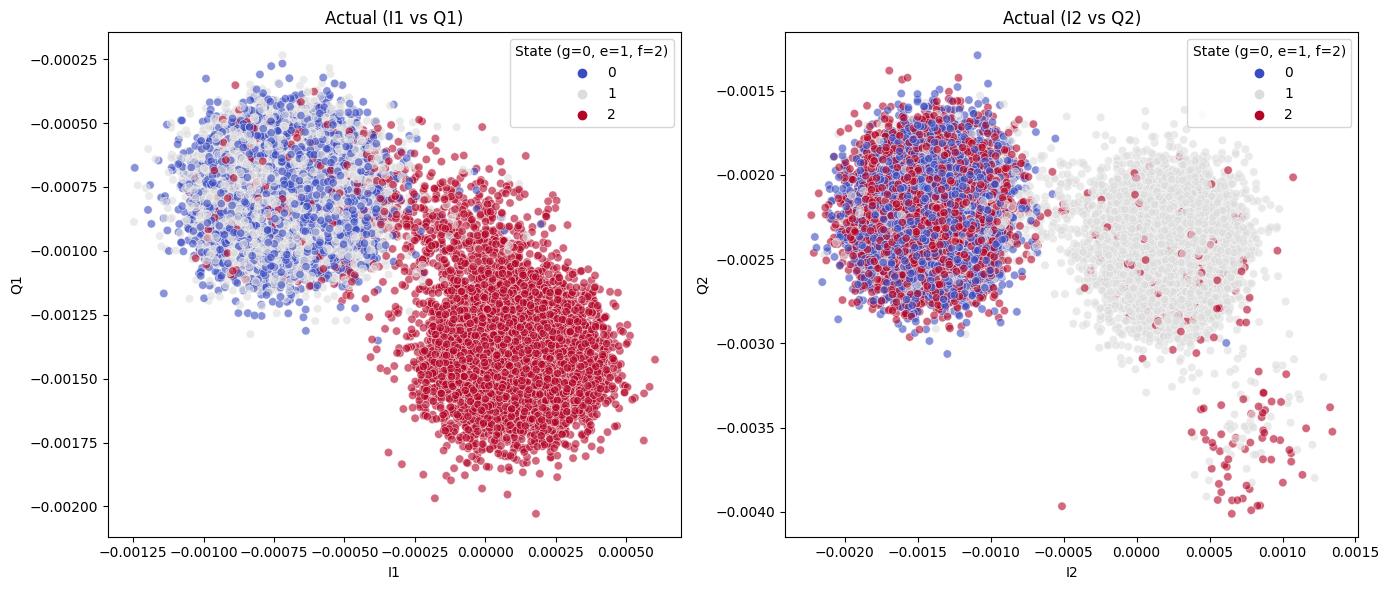

In [10]:
# Create subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First subplot: I1 vs Q1
sns.scatterplot(
    data=three_state,
    x="I1",
    y="Q1",
    hue="label",
    palette="coolwarm",
    alpha=0.6,
    ax=axes[0],
)
axes[0].set_xlabel("I1")
axes[0].set_ylabel("Q1")
axes[0].set_title("Actual (I1 vs Q1)")
axes[0].legend(title="State (g=0, e=1, f=2)", loc="upper right")

# Second subplot: I2 vs Q2
sns.scatterplot(
    data=three_state,
    x="I2",
    y="Q2",
    hue="label",
    palette="coolwarm",
    alpha=0.6,
    ax=axes[1],
)
axes[1].set_xlabel("I2")
axes[1].set_ylabel("Q2")
axes[1].set_title("Actual (I2 vs Q2)")
axes[1].legend(title="State (g=0, e=1, f=2)", loc="upper right")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

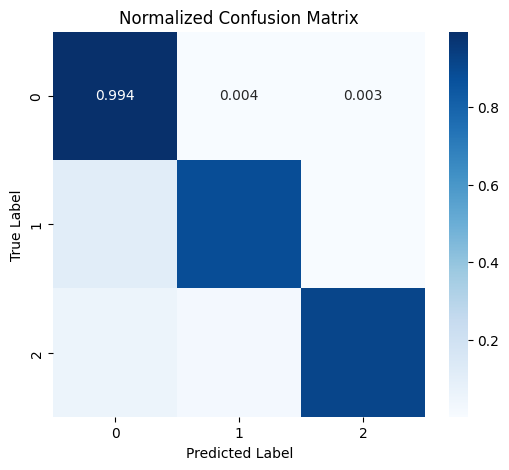

In [18]:
plt.figure(figsize=(6, 5))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt=".3f",
    cmap="Blues",
    xticklabels=[0, 1, 2],
    yticklabels=[0, 1, 2],
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.show()

In [15]:
print(conf_matrix.shape)

(3, 3)


In [12]:
import numpy as np

np.linalg.inv(conf_matrix)

array([[ 1.0072214 , -0.00449152, -0.00272988],
       [-0.12994305,  1.13517082, -0.00522777],
       [-0.06187555, -0.03134384,  1.09321938]])

In [13]:
np.linalg.inv(
    [
        [1.02181452, -0.01073271, -0.01108182],
        [-0.22394639, 1.26065883, -0.03671244],
        [-0.20113232, -0.11916995, 1.32030227],
    ]
)

array([[0.98233334, 0.00916667, 0.0085    ],
       [0.17933333, 0.797     , 0.02366667],
       [0.16583333, 0.07333333, 0.76083334]])